Inverse Reinforcement Learning (IRL) involves learning the reward function from demonstrations provided by an expert (or a human). Combining IRL with human feedback can help improve the agent's performance by refining its understanding of the reward function based on the feedback. Here's how you can implement IRL with human feedback in a CartPole environment using Python:

# Step 1: Define the Environment and Models
We'll define a reward model, a policy model, and a preference model. The reward model learns the reward function from the state-action pairs, the policy model represents the agent's policy, and the preference model simulates human feedback.

# Step 2: Implement the IRL Algorithm
We will use Maximum Entropy IRL, where the goal is to find a reward function such that the policy learned from this reward function matches the demonstrated behavior.

# Step 3: Integrate Human Feedback
Simulate human feedback by providing preferences between pairs of trajectories. The preference model learns from these preferences and refines the reward function.


# Explanation of the Code
**RewardModel**: Learns the reward function based on state inputs.

**PolicyModel**: Learns the policy based on state inputs.

**PreferenceModel**: Learns from human preferences by comparing pairs of state-action pairs.

**IRLAgent**: Implements the IRL algorithm with human feedback.

**train**: Trains the agent in the environment and updates models based on experiences and human preferences.

**main**: Runs the training process and plots the rewards.

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-1-51faaaa16040>:83: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarra

Episode 1/200, Total Reward: 16.0
Episode 2/200, Total Reward: 29.0
Episode 3/200, Total Reward: 11.0
Episode 4/200, Total Reward: 15.0
Episode 5/200, Total Reward: 9.0
Episode 6/200, Total Reward: 38.0
Episode 7/200, Total Reward: 18.0
Episode 8/200, Total Reward: 28.0
Episode 9/200, Total Reward: 10.0
Episode 10/200, Total Reward: 39.0
Episode 11/200, Total Reward: 26.0
Episode 12/200, Total Reward: 30.0
Episode 13/200, Total Reward: 20.0
Episode 14/200, Total Reward: 12.0
Episode 15/200, Total Reward: 61.0
Episode 16/200, Total Reward: 15.0
Episode 17/200, Total Reward: 77.0
Episode 18/200, Total Reward: 63.0
Episode 19/200, Total Reward: 16.0
Episode 20/200, Total Reward: 67.0
Episode 21/200, Total Reward: 82.0
Episode 22/200, Total Reward: 109.0
Episode 23/200, Total Reward: 125.0
Episode 24/200, Total Reward: 90.0
Episode 25/200, Total Reward: 72.0
Episode 26/200, Total Reward: 27.0
Episode 27/200, Total Reward: 83.0
Episode 28/200, Total Reward: 109.0
Episode 29/200, Total Rewar

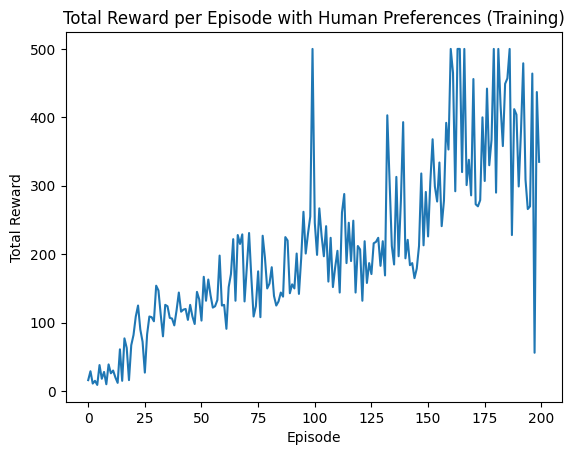

Evaluation Episode 1/100, Total Reward: 373.0
Evaluation Episode 2/100, Total Reward: 363.0
Evaluation Episode 3/100, Total Reward: 500.0
Evaluation Episode 4/100, Total Reward: 500.0
Evaluation Episode 5/100, Total Reward: 500.0
Evaluation Episode 6/100, Total Reward: 402.0
Evaluation Episode 7/100, Total Reward: 500.0
Evaluation Episode 8/100, Total Reward: 500.0
Evaluation Episode 9/100, Total Reward: 500.0
Evaluation Episode 10/100, Total Reward: 500.0
Evaluation Episode 11/100, Total Reward: 413.0
Evaluation Episode 12/100, Total Reward: 500.0
Evaluation Episode 13/100, Total Reward: 500.0
Evaluation Episode 14/100, Total Reward: 500.0
Evaluation Episode 15/100, Total Reward: 500.0
Evaluation Episode 16/100, Total Reward: 500.0
Evaluation Episode 17/100, Total Reward: 478.0
Evaluation Episode 18/100, Total Reward: 500.0
Evaluation Episode 19/100, Total Reward: 500.0
Evaluation Episode 20/100, Total Reward: 500.0
Evaluation Episode 21/100, Total Reward: 500.0
Evaluation Episode 22/

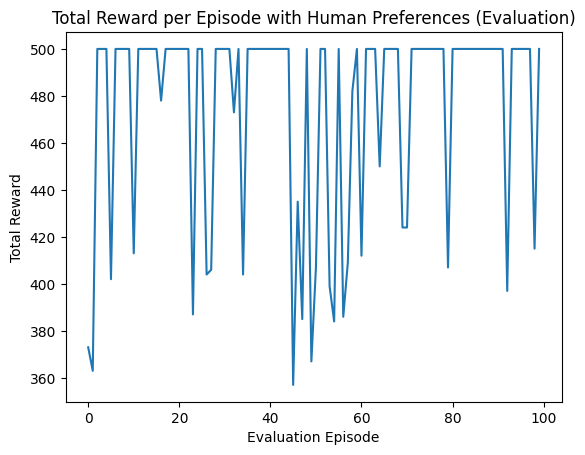

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

class RewardModel(nn.Module):
    def __init__(self, state_dim):
        super(RewardModel, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class PolicyModel(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyModel, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class PreferenceModel(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PreferenceModel, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, state, action):
        x = torch.cat((state, action), dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class IRLAgent:
    def __init__(self, env, alpha=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01, memory_size=10000, batch_size=64):
        self.env = env
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.reward_model = RewardModel(self.state_dim)
        self.policy_model = PolicyModel(self.state_dim, self.action_dim)
        self.preference_model = PreferenceModel(self.state_dim, 1)
        self.optimizer = optim.Adam(self.policy_model.parameters(), lr=alpha)
        self.reward_optimizer = optim.Adam(self.reward_model.parameters(), lr=alpha)
        self.preference_optimizer = optim.Adam(self.preference_model.parameters(), lr=alpha)
        self.steps_done = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.policy_model(state)
        return torch.argmax(q_values).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)

        state_batch = torch.FloatTensor(state_batch)
        action_batch = torch.LongTensor(action_batch).unsqueeze(1)
        reward_batch = torch.FloatTensor(reward_batch).unsqueeze(1)
        next_state_batch = torch.FloatTensor(next_state_batch)
        done_batch = torch.FloatTensor(done_batch).unsqueeze(1)

        q_values = self.policy_model(state_batch).gather(1, action_batch)
        next_q_values = self.policy_model(next_state_batch).max(1)[0].unsqueeze(1)
        target_q_values = reward_batch + self.gamma * next_q_values * (1 - done_batch)

        loss = nn.MSELoss()(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay

    def get_human_preference(self, state1, action1, state2, action2):
        # Simulate human preference
        reward1 = -1 if abs(state1[0, 2]) > 0.1 else 1
        reward2 = -1 if abs(state2[0, 2]) > 0.1 else 1
        return reward1 > reward2

    def update_preference_model(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        for state1, action1, reward1, next_state1, done1 in batch:
            state2, action2, reward2, next_state2, done2 = random.choice(self.memory)
            action1 = torch.FloatTensor([action1]).unsqueeze(0)
            action2 = torch.FloatTensor([action2]).unsqueeze(0)
            state1 = torch.FloatTensor(state1).unsqueeze(0)
            state2 = torch.FloatTensor(state2).unsqueeze(0)
            preference = self.get_human_preference(state1, action1, state2, action2)

            pred1 = self.preference_model(state1, action1)
            pred2 = self.preference_model(state2, action2)
            preference_target = torch.FloatTensor([[1.0], [0.0]]) if preference else torch.FloatTensor([[0.0], [1.0]])

            loss = nn.BCEWithLogitsLoss()(torch.cat((pred1, pred2)), preference_target)
            self.preference_optimizer.zero_grad()
            loss.backward()
            self.preference_optimizer.step()

def train(env, agent, episodes):
    rewards = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            agent.replay()
            agent.update_preference_model()
            state = next_state
            total_reward += reward

        rewards.append(total_reward)
        print(f"Episode {episode+1}/{episodes}, Total Reward: {total_reward}")
    return rewards

def evaluate(env, agent, episodes=100):
    total_rewards = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.act(state)
            state, reward, done, _ = env.step(action)
            total_reward += reward
        total_rewards.append(total_reward)
        print(f"Evaluation Episode {episode+1}/{episodes}, Total Reward: {total_reward}")
    return total_rewards

# Main function to run the training
def main():
    env = gym.make('CartPole-v1')
    agent = IRLAgent(env)
    episodes = 200
    rewards = train(env, agent, episodes)

    # Plot the training rewards
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode with Human Preferences (Training)')
    plt.show()

    # Evaluate the trained agent
    evaluation_rewards = evaluate(env, agent)

    # Plot the evaluation rewards
    plt.plot(evaluation_rewards)
    plt.xlabel('Evaluation Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode with Human Preferences (Evaluation)')
    plt.show()

if __name__ == "__main__":
    main()
